# HR - аналитика

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# Задача 1 - предсказание уровня удовлетворённости сотрудника

Для этой задачи заказчик предоставил данные с признаками:
* `id` — уникальный идентификатор сотрудника;
* `dept` — отдел, в котором работает сотрудник;
* `level` — уровень занимаемой должности;
* `workload` — уровень загруженности сотрудника;
* `employment_years` — длительность работы в компании (в годах);
* `last_year_promo` — показывает, было ли повышение за последний год;
* `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
* `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
* `salary` — ежемесячная зарплата сотрудника;
* `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [1]:
%pip install phik -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install shap -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
! pip install scikit-learn==1.2.0 -q


[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import sklearn
sklearn.__version__

'1.2.0'

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, make_scorer 
from sklearn.impute import SimpleImputer
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import shap

## Загрузка данных и общая информация

In [6]:
try:
    train_satisf_df = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
    test_satisf_features_df = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    test_satisf_target_df = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')
except:
    print("Загрузка файлов не удалась!")

In [7]:
display(train_satisf_df.head(10))
print('-------------------------------------')
train_satisf_df.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


-------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


В столбцах `dept` и `level` датасета `train_satisf_df` пропущено 6 и 4 значений соответственно. Данные в столбцах имеют соответствующий тип данных.

In [8]:
display(test_satisf_features_df.head(10))
print('-------------------------------------')
test_satisf_features_df.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


-------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


В столбцах `dept` и `level` датасета `test_satisf_features_df` пропущено 2 и 1 значений соответственно. Данные в столбцах имеют соответствующий тип данных.

In [9]:
display(test_satisf_target_df.head(10))
print('-------------------------------------')
test_satisf_target_df.info()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


-------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


В датасете `test_satisf_target_df` пропущенных значений нет. Данные в столбцах имеют соответствующий тип данных.

## Предобработка данных

#### Поиск явных дубликатов

In [10]:
print(f'Кол-во явных дубликатов в "train_satisf_df": {train_satisf_df.duplicated().sum()}')
print(f'Кол-во явных дубликатов в "test_satisf_features_df": {test_satisf_features_df.duplicated().sum()}')
print(f'Кол-во явных дубликатов в "test_satisf_target_df": {test_satisf_target_df.duplicated().sum()}')

Кол-во явных дубликатов в "train_satisf_df": 0
Кол-во явных дубликатов в "test_satisf_features_df": 0
Кол-во явных дубликатов в "test_satisf_target_df": 0


Явных дубликатов не найдено ни в одном из датафреймов.

#### Поиск неявных дубликатов

In [11]:
for column in train_satisf_df.columns:
    if train_satisf_df[column].dtype == 'object': 
        print(f'Поиск неявных дубликатов для столбца {column}:')
        print(train_satisf_df[column].value_counts())
        print('-----------------------')

Поиск неявных дубликатов для столбца dept:
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64
-----------------------
Поиск неявных дубликатов для столбца level:
junior    1894
middle    1744
sinior     358
Name: level, dtype: int64
-----------------------
Поиск неявных дубликатов для столбца workload:
medium    2066
low       1200
high       734
Name: workload, dtype: int64
-----------------------
Поиск неявных дубликатов для столбца last_year_promo:
no     3880
yes     120
Name: last_year_promo, dtype: int64
-----------------------
Поиск неявных дубликатов для столбца last_year_violations:
no     3441
yes     559
Name: last_year_violations, dtype: int64
-----------------------


Неявных дубликатов в датасете `train_satisf_df` не найдено. 

In [12]:
for column in test_satisf_features_df.columns:
    if test_satisf_features_df[column].dtype == 'object': 
        print(f'Поиск неявных дубликатов для столбца {column}:')
        print(test_satisf_features_df[column].value_counts())
        print('-----------------------')

Поиск неявных дубликатов для столбца dept:
sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64
-----------------------
Поиск неявных дубликатов для столбца level:
junior    974
middle    854
sinior    171
Name: level, dtype: int64
-----------------------
Поиск неявных дубликатов для столбца workload:
medium    1043
low        593
high       363
             1
Name: workload, dtype: int64
-----------------------
Поиск неявных дубликатов для столбца last_year_promo:
no     1937
yes      63
Name: last_year_promo, dtype: int64
-----------------------
Поиск неявных дубликатов для столбца last_year_violations:
no     1738
yes     262
Name: last_year_violations, dtype: int64
-----------------------


Неявных дубликатов в датасете `test_satisf_features_df` не найдено. При этом в столбцах `dept`, `workload` были найдены по 1 пустому значению.

## Исследовательский анализ данных

### Статистический анализ признаков датасета `train_satisf_df`

In [13]:
# Функция для построения boxplot и hist (для числовых признаков)
def box_hist_plot(df, column, bins, plot_name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    df.boxplot(column=column, ax=axes[0])
    axes[0].set_title('Boxplot')
    axes[0].tick_params(axis='x', labelbottom=False)
    axes[0].set_ylabel(column)

    df[column].hist(bins=bins, ax=axes[1])
    axes[1].set_title('Histogram')
    axes[1].set_xlabel(column)

    fig.suptitle(plot_name, y=1.05)

    display(df[column].describe())
    IQR = df[column].describe()['75%'] - df[column].describe()['25%']
    Q1_minus = df[column].describe()['25%'] - 1.5 * IQR
    Q3_plus = df[column].describe()['75%'] + 1.5 * IQR
    
    print(f"Усы боксплота: ({Q1_minus}, {Q3_plus})")

# Функция для построения pie chart (для категориальных признаков)
def pie_chart(df, column, plot_name):

    allvals_sum = df.shape[0] 
    dt_temp = df.pivot_table(index=column, aggfunc='count')
    dt = dt_temp[dt_temp.columns[0]] 
    dt_legend = df.pivot_table(index=column, aggfunc='count').reset_index()[column].tolist()
    
    def func(pct):
        absolute = float(pct/100.*allvals_sum)
        return "{:.1f}%\n({:.0f})".format(pct, absolute)

    fig, ax = plt.subplots(figsize=(12, 5), subplot_kw=dict(aspect="equal"))

    wedges, texts, autotexts = ax.pie(dt, autopct=lambda pct: func(pct), textprops=dict(color="w"))

    ax.legend(wedges, dt_legend,
            # title="",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size = 8, weight ="bold")
    ax.set_title(plot_name)

    # show plot
    plt.show()

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

Усы боксплота: (-7800.0, 73800.0)


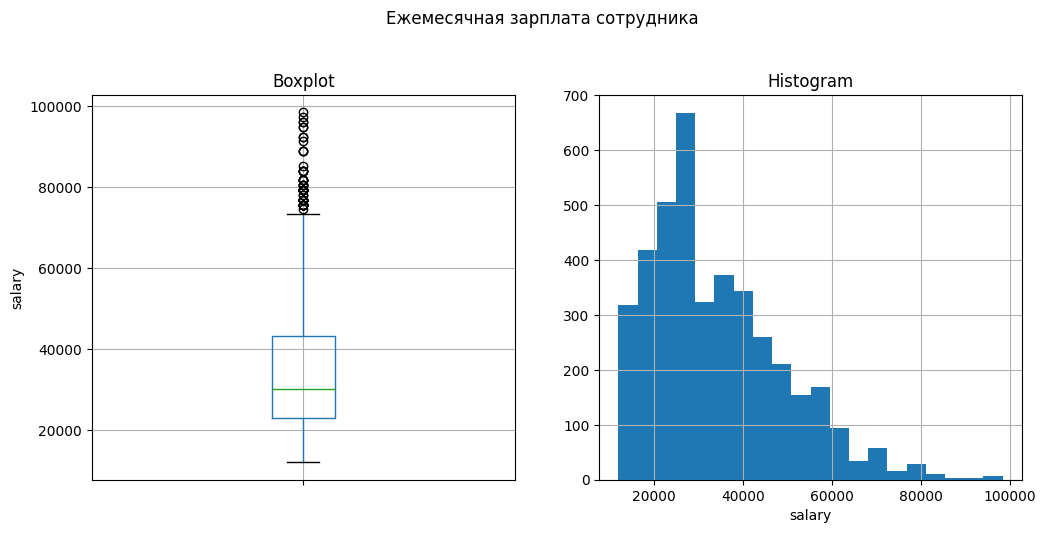

In [14]:
box_hist_plot(train_satisf_df, 'salary', 20, 'Ежемесячная зарплата сотрудника')

В датасете `train_satisf_df` для столбца `salary` обнаружены выбросы, сгрупиированные у верхнего "уса" боксплота.

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

Усы боксплота: (-0.16499999999999992, 1.2349999999999999)


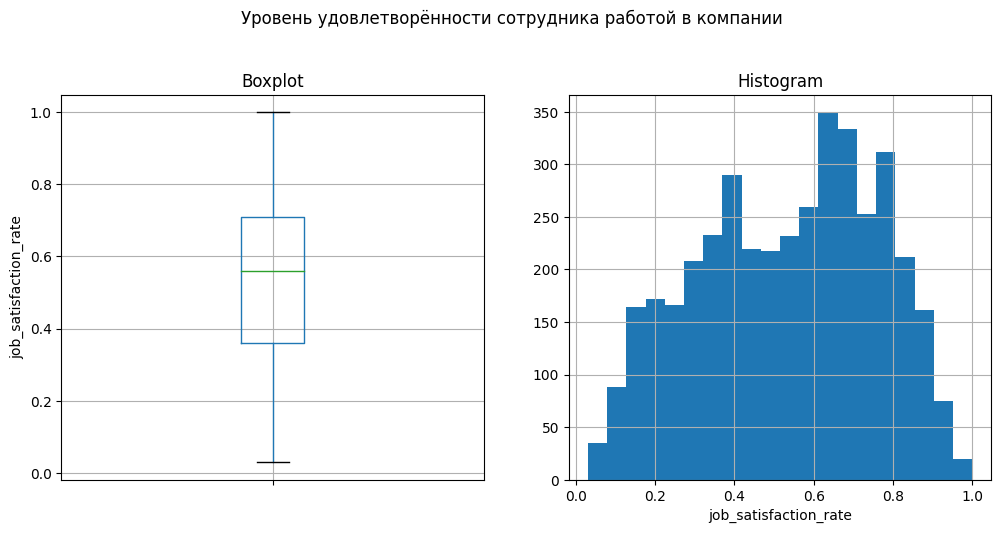

In [15]:
box_hist_plot(train_satisf_df, 'job_satisfaction_rate', 20, 'Уровень удовлетворённости сотрудника работой в компании')

В датасете `train_satisf_df` для столбца `job_satisfaction_rate` не обнаружено выбросов.

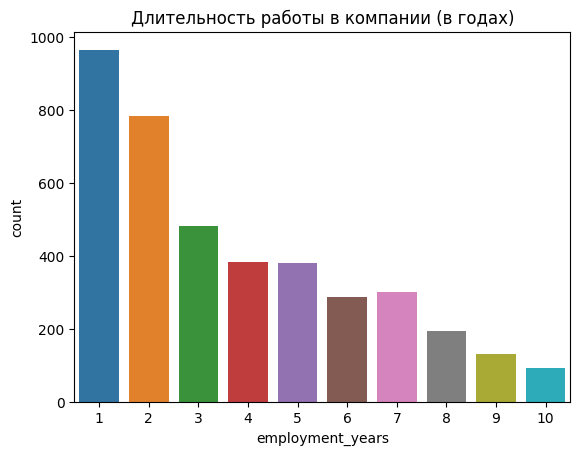

In [16]:
sns.countplot(data=train_satisf_df, x='employment_years')
plt.title('Длительность работы в компании (в годах)');

Для столбца `employment_years` датасета `train_satisf_df` определено, что большая часть сотрудников работает в компании 1-2 года.

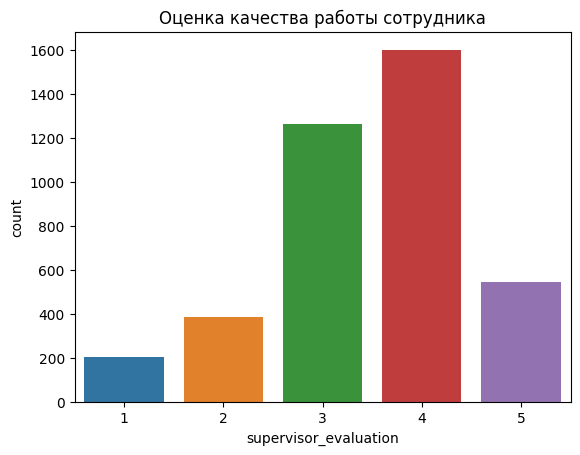

In [17]:
sns.countplot(data=train_satisf_df, x='supervisor_evaluation')
plt.title('Оценка качества работы сотрудника');

Для столбца `supervisor_evaluation` датасета `train_satisf_df` определено, что большая часть сотрудников получила оценку 3 или 4.

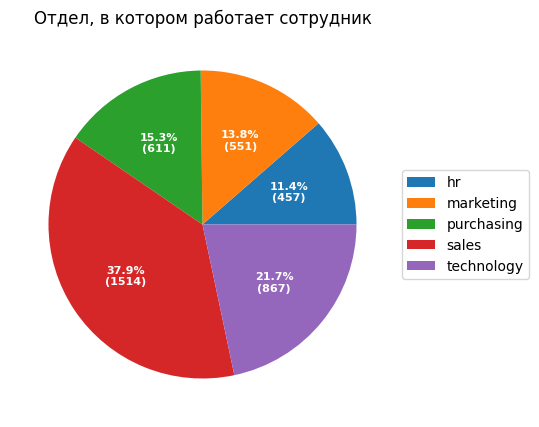

In [18]:
pie_chart(train_satisf_df, 'dept', 'Отдел, в котором работает сотрудник')

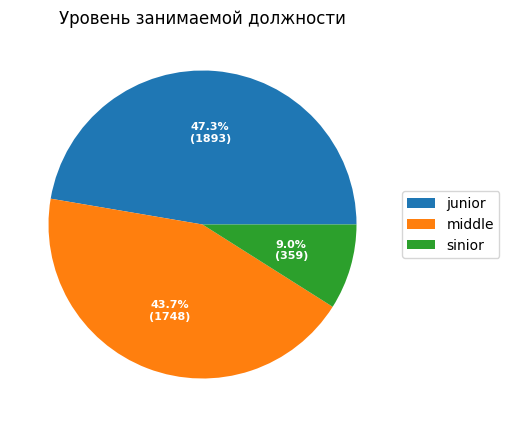

In [19]:
pie_chart(train_satisf_df, 'level', 'Уровень занимаемой должности')

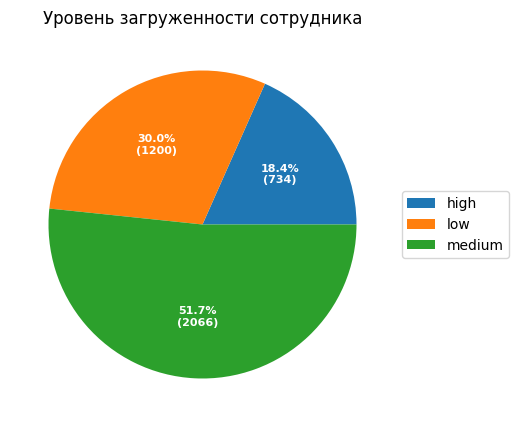

In [20]:
pie_chart(train_satisf_df, 'workload', 'Уровень загруженности сотрудника')

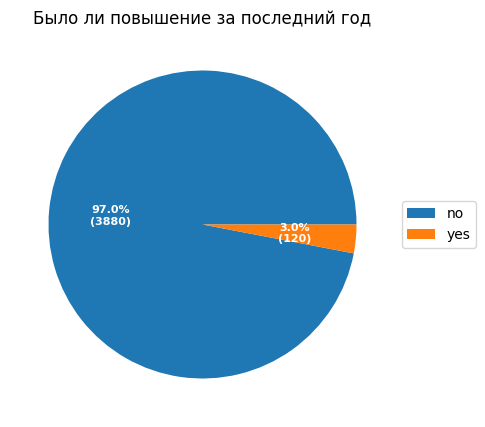

In [21]:
pie_chart(train_satisf_df, 'last_year_promo', 'Было ли повышение за последний год')

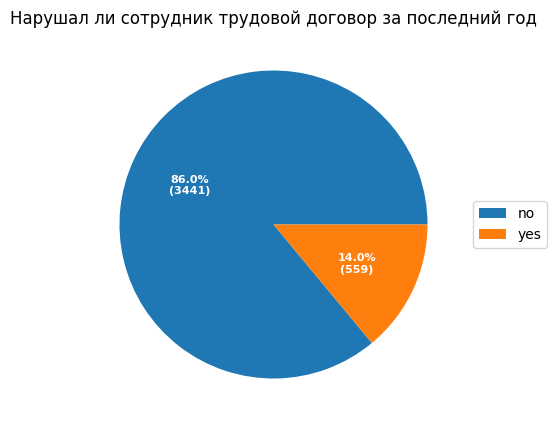

In [22]:
pie_chart(train_satisf_df, 'last_year_violations', 'Нарушал ли сотрудник трудовой договор за последний год')

**Вывод:** Распределения количественных признаков датафрейма `train_satisf_df` не имеют явно выраженного нормального распределения. У признака `salary` обнаружен выбросы. Для категориальных признаков определено следующее: большая часть сотрудников занята в отделе продаж, имеют уровень junior,  работают в компании от 1-2 лет, имеет оценку 3-4, средний уровень нагрузки, не получили повышения за последний год и не нарушали трудового договора за последний год.

### Статистический анализ признаков test-выборки 

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

Усы боксплота: (-7800.0, 73800.0)


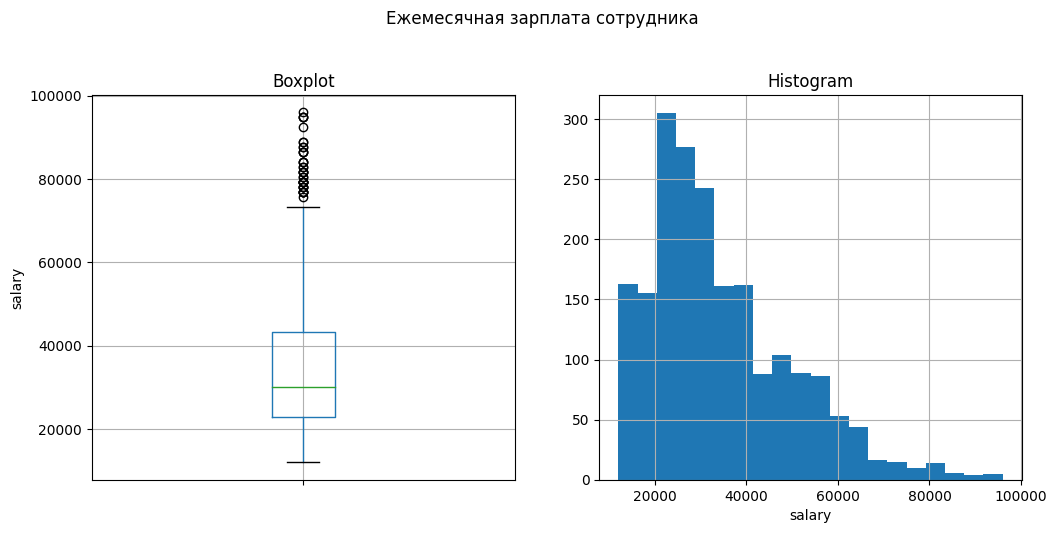

In [23]:
box_hist_plot(test_satisf_features_df, 'salary', 20, 'Ежемесячная зарплата сотрудника')

В датасете `test_satisf_features_df` для столбца `salary` обнаружены выбросы, сгрупиированные у верхнего "уса" боксплота.

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

Усы боксплота: (-0.13, 1.23)


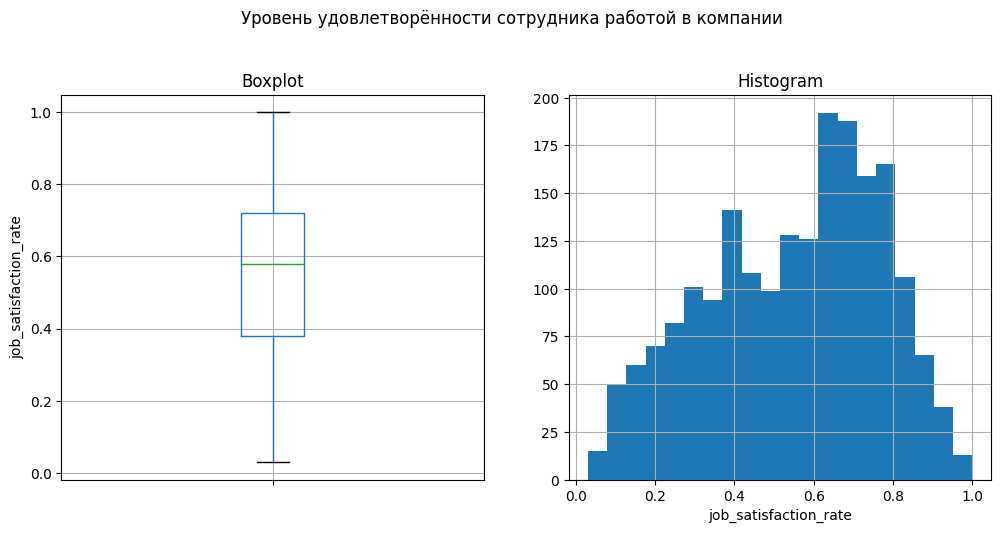

In [24]:
box_hist_plot(test_satisf_target_df, 'job_satisfaction_rate', 20, 'Уровень удовлетворённости сотрудника работой в компании')

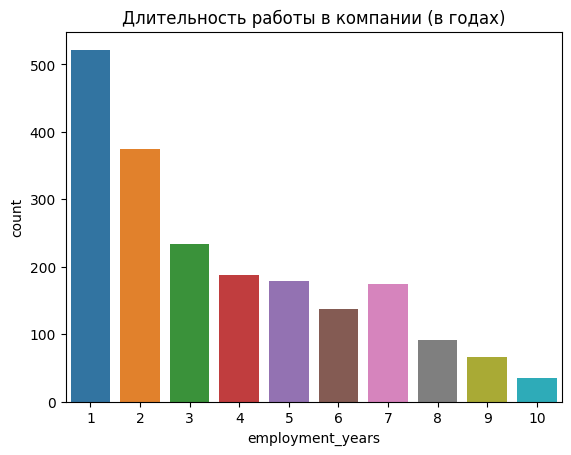

In [25]:
sns.countplot(data=test_satisf_features_df, x='employment_years')
plt.title('Длительность работы в компании (в годах)');

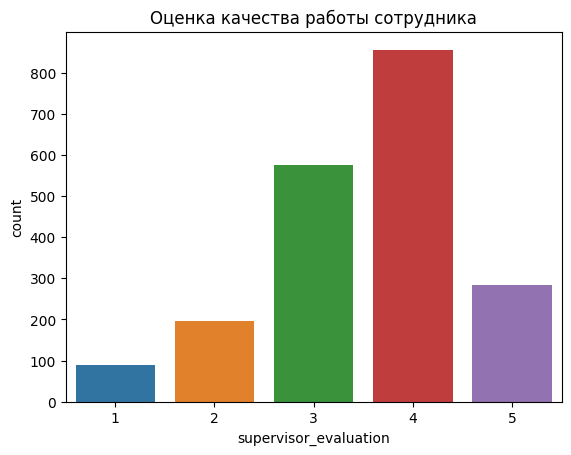

In [26]:
sns.countplot(data=test_satisf_features_df, x='supervisor_evaluation')
plt.title('Оценка качества работы сотрудника');

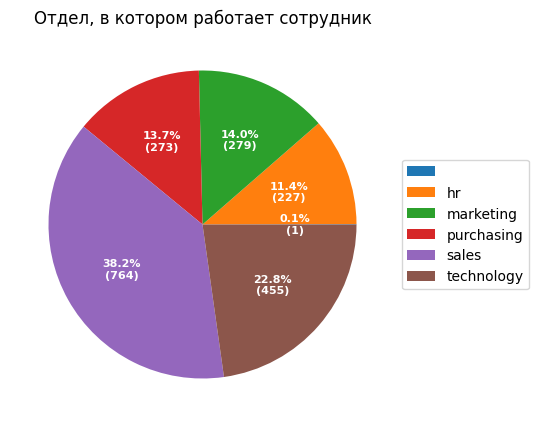

In [27]:
pie_chart(test_satisf_features_df, 'dept', 'Отдел, в котором работает сотрудник')

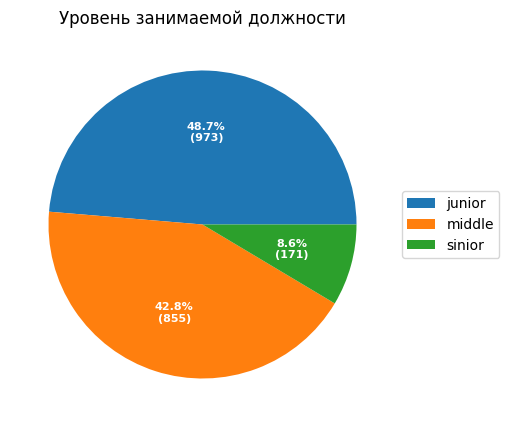

In [28]:
pie_chart(test_satisf_features_df, 'level', 'Уровень занимаемой должности')

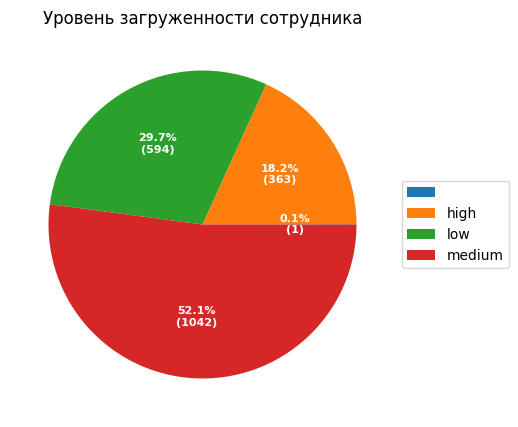

In [29]:
pie_chart(test_satisf_features_df, 'workload', 'Уровень загруженности сотрудника')

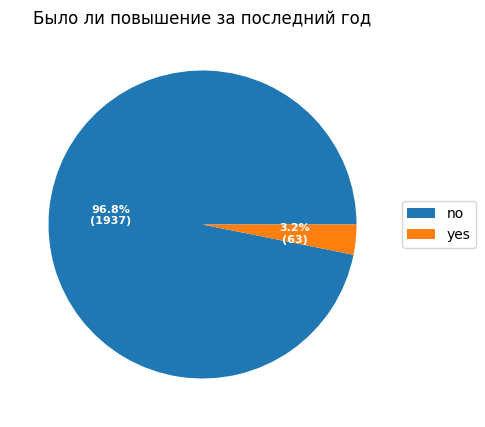

In [30]:
pie_chart(test_satisf_features_df, 'last_year_promo', 'Было ли повышение за последний год')

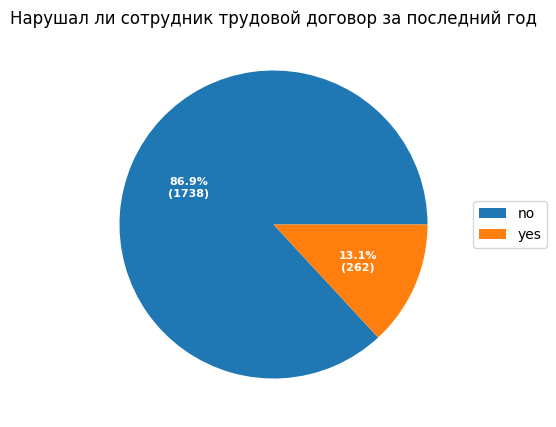

In [31]:
pie_chart(test_satisf_features_df, 'last_year_violations', 'Нарушал ли сотрудник трудовой договор за последний год')

**Вывод:** Распределения количественных и категориальных признаков test-датасета аналогично train-датасету `train_satisf_df`.

### Корреляционный анализ `train_satisf_df`

In [32]:
# Создадим список с названиями столбцов непрерывных признаков
interval_cols = ['salary', 'job_satisfaction_rate']

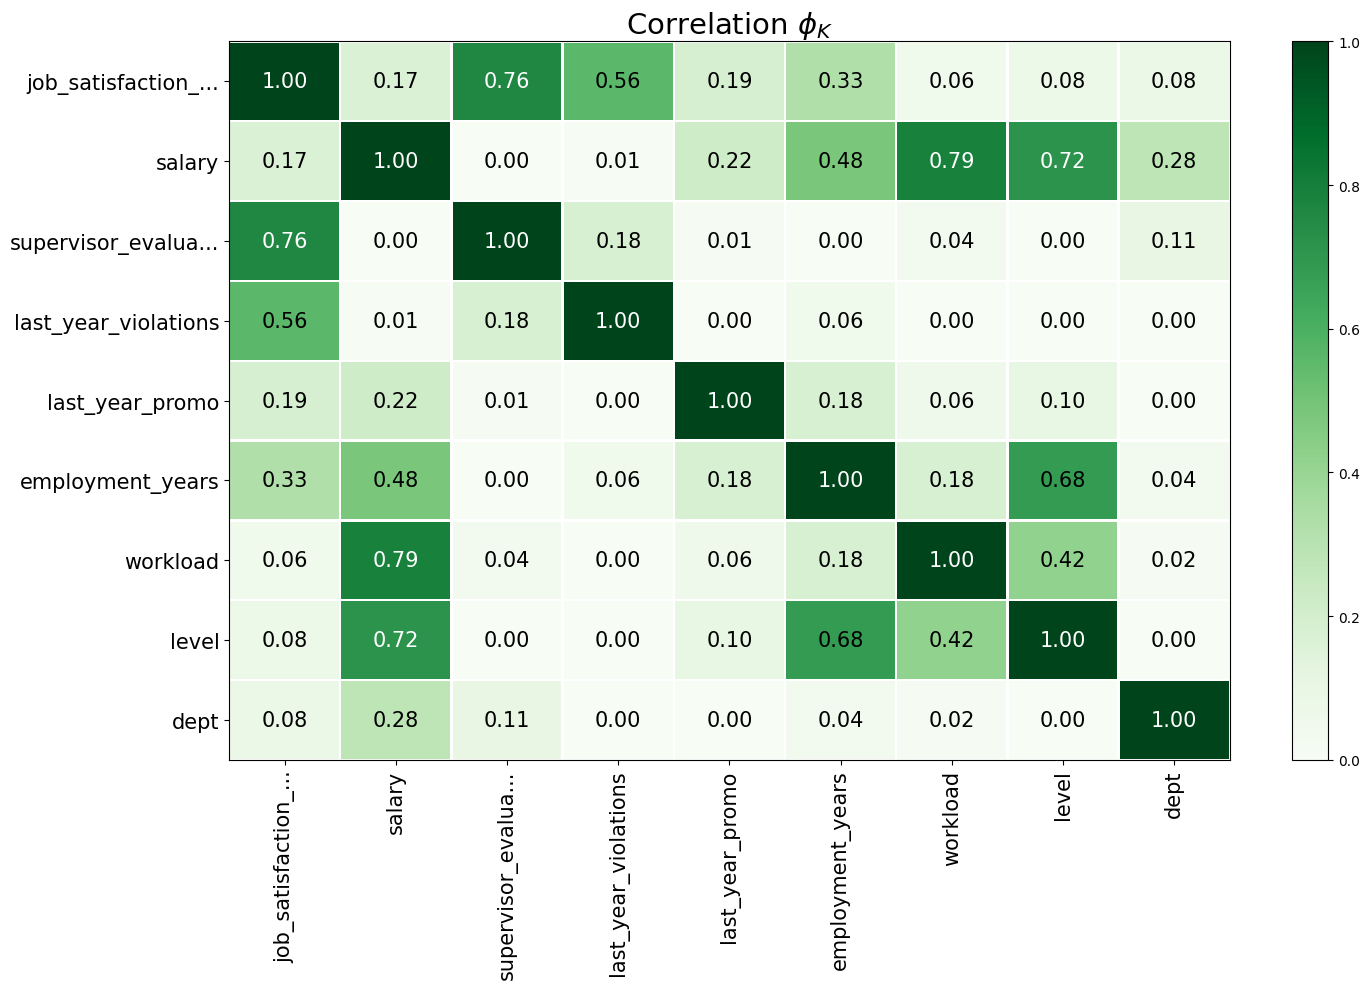

In [33]:
phik_overview = phik_matrix(train_satisf_df.drop('id', axis=1), interval_cols = interval_cols)

# Визуализация матрицы корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens', 
    title=r'Correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
)

Если принять за значение мультиколлинеарности значения 0,9 и выше, то в исследуемом датасете ее не наблюдается.

С таргетом `job_satisfaction_rate` (уровень удовлетворённости сотрудника) наиболее значительно коррелируют:
* `supervisor_evaluation` - 0.76
* `last_year_violations` - 0.56
* `employment_years` - 0.33

Все остальные признаки коррелируют незначительно - от 0,06 до 0,19.

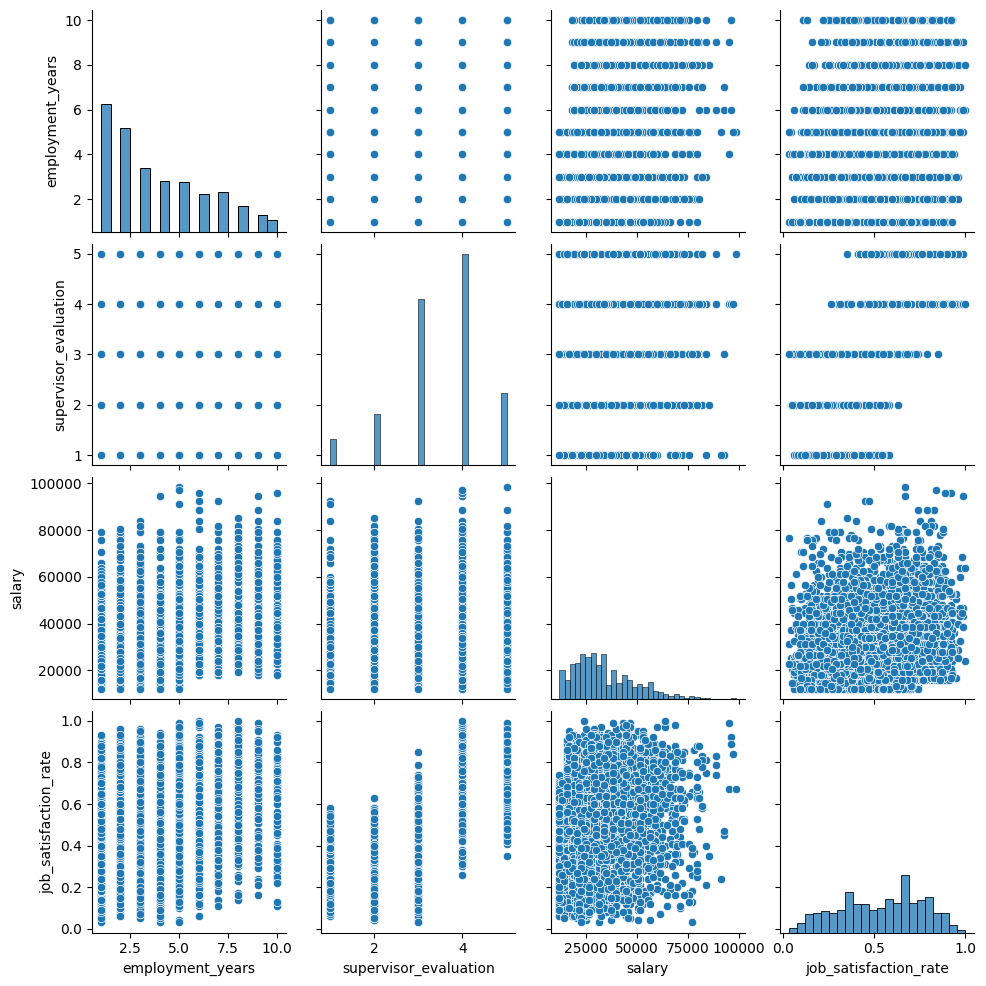

In [34]:
# Используем scatterplot matrix для анализа связи между таргетом и числовыми признаками
train_satisf_df_scatter = train_satisf_df[['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']]
sns.pairplot(train_satisf_df_scatter)

Как видно из полученных графиков линейная связь между таргетом и числовыми признаками не прослеживается.

### Корреляционный анализ `test_satisf_df`

In [35]:
# Предварительно соединим таблицы тестовых датасетов (таргета и входных признаков)
test_satisf_df = test_satisf_features_df.merge(test_satisf_target_df, on='id')

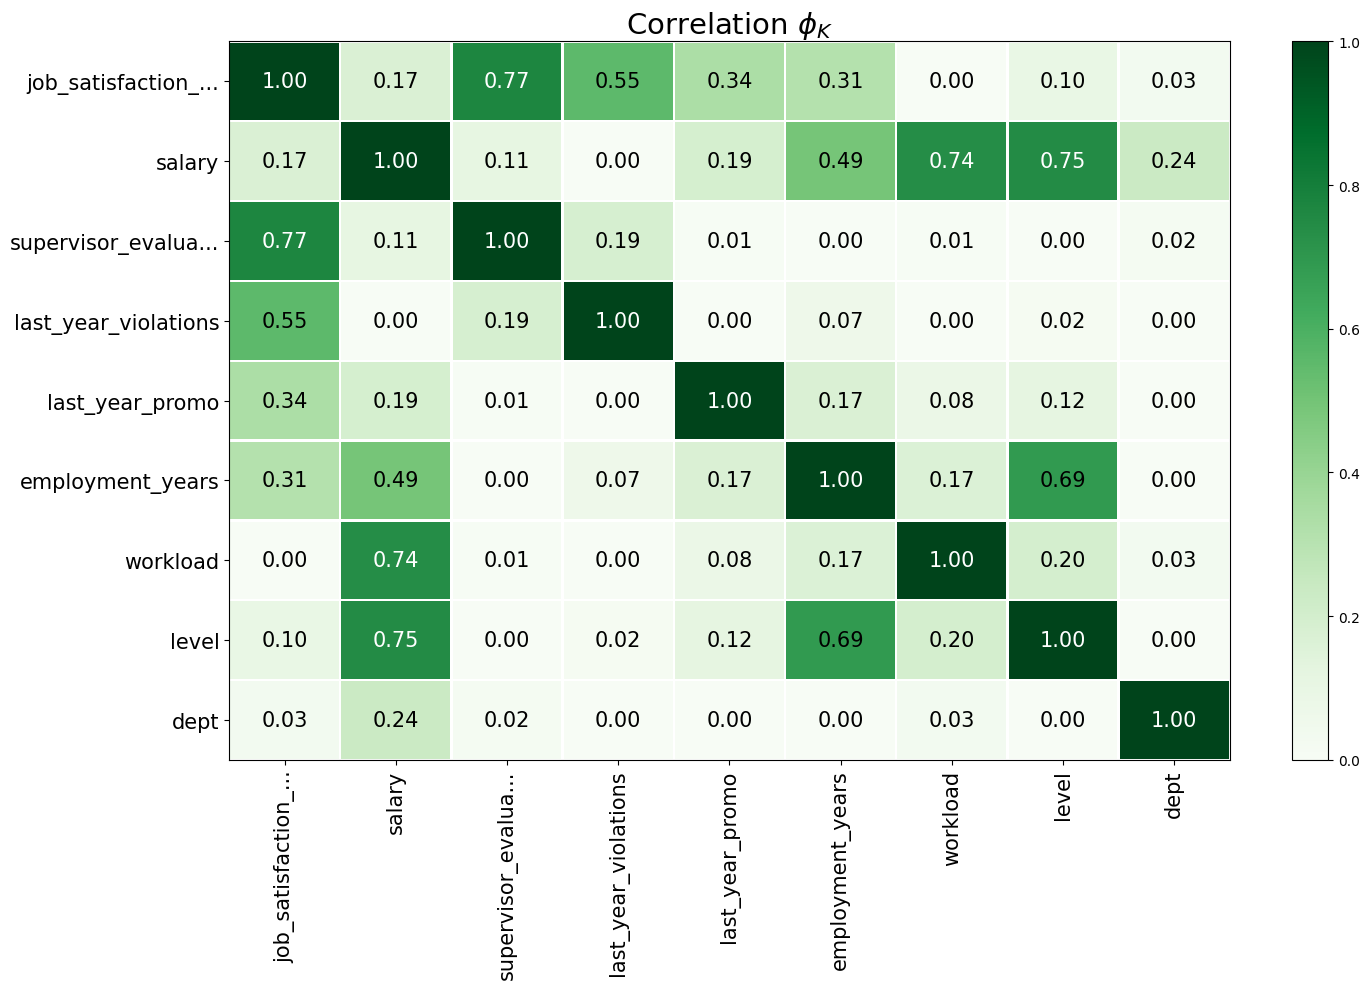

In [36]:
phik_overview = phik_matrix(test_satisf_df.drop('id', axis=1), interval_cols = interval_cols)

# Визуализация матрицы корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens', 
    title=r'Correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
)

Корреляция с таргетом входных признаков test-датасета аналогична train-датасету.

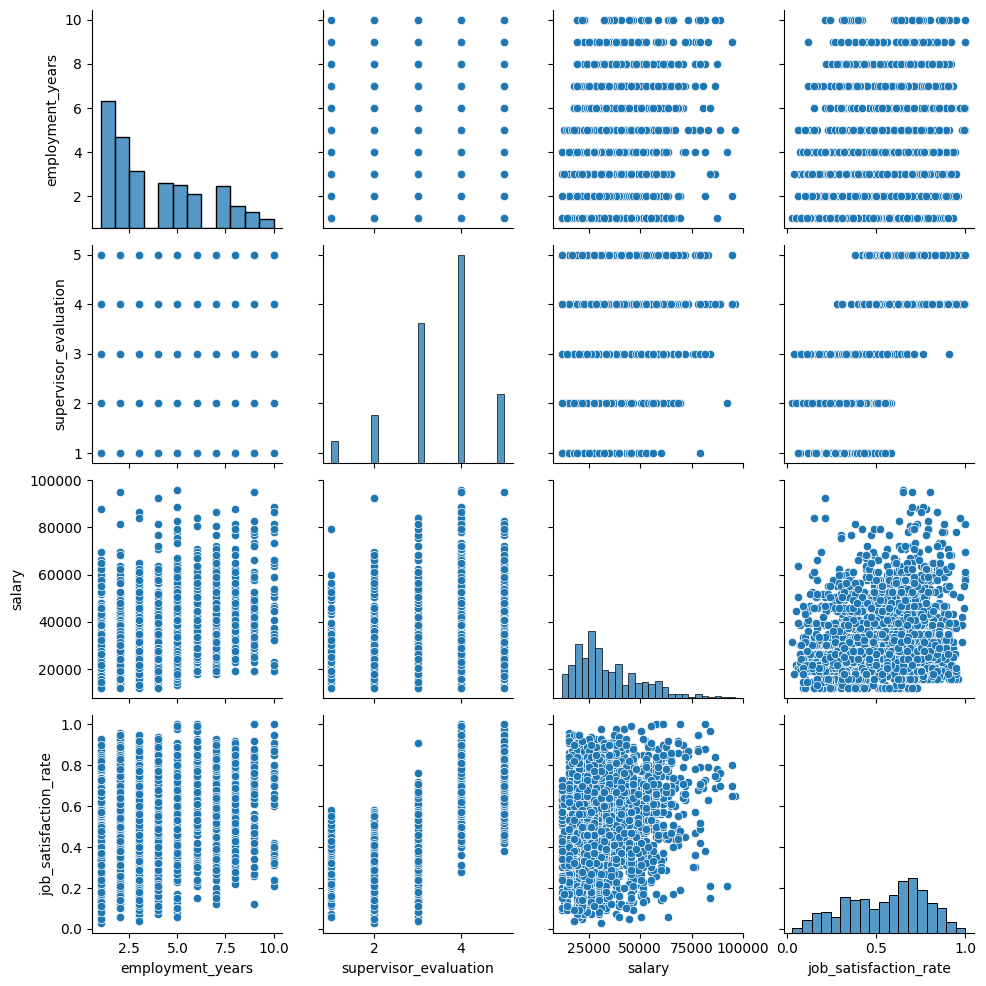

In [37]:
test_satisf_df_scatter = test_satisf_df[['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']]
sns.pairplot(test_satisf_df_scatter)

Взаимосвязи признаков test-датасета аналогичны train-датасету.

## Пайплайн и обучение модели

### Выборки датасета и пайплайн подготовки данных

In [38]:
# Определим колонки которые нужно масштабировать и закодировать
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

RANDOM_STATE = 42

In [39]:
# Удалим id и произведем проверку на дубликаты
X_train_init = train_satisf_df.drop(['id'], axis=1)
X_train_init.duplicated().sum()

245

Было найдено 245 строк-дубликатов после удаления признака `id`. Удалим их:

In [40]:
X_train_init = X_train_init.drop_duplicates()
X_train_init.shape

(3755, 9)

Явные дубликаты после удаления `id` были успешно удалены.

In [41]:
X_train = X_train_init.drop(['job_satisfaction_rate'], axis=1)
y_train = X_train_init['job_satisfaction_rate']

In [42]:
# Определим пайплайн предобработки данных
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False) # Работает только с sklearn от 1.0.0 и выше
        )
    ]
)

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')

        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['sinior', 'middle', 'junior'],
                    ['high', 'medium', 'low']   
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)       
    ], 
    remainder='passthrough'
)

### Обучение и подбор наилучшей модели

Для обучения используем 2 модели: модель линейной регрессии (*LinearRegression*) и дерево решений (*DecisionTreeRegressor*). Для последней модели проведем подбор наилучших гиперпарметров с использованием метрики SMAPE (симметричное среднее абсолютное процентное отклонение):

In [43]:
# Определим функцию для расчета метрики 
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) 

In [44]:
# Определим пользовательскую метрику
smape_scorer = make_scorer(smape, greater_is_better=False) 

Подбор наилучшей модели выполним с помощью пайплайна:

In [45]:
# Определим итоговый пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression()) 
])

# Определим словарь гиперпараметров (с вариацией масштабирования и моделей)
param_grid = [
    # LinearRegression
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), RobustScaler()]
    },
    # DecisionTreeRegressor 
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5,15),
        'models__max_features': range(5,15),
        'preprocessor__num': [StandardScaler(), RobustScaler()]        
    }
]

# Для подбора гиперпараметров используем случайный поиск
rs = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rs.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', rs.best_estimator_)
print ('Метрика SMAPE лучшей модели на кросс-валидации:', (-1) * rs.best_score_)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

Лучшая модель - Дерево решений (*DecisionTreeRegressor*) с параметрами *max_depth* (глубина дерева) = 13, *max_features* (кол-во признаков для наилучшего разделения) = 10 и методом масштабирования *StandardScaler*. Значение метрики SMAPE для полученной модели составлило 15.5%.

Протестируем модель на тестовых данных с использованием метрики SHAPE:

In [46]:
# Сначала соберем тестовый датасет 
X_test = test_satisf_df.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = test_satisf_df['job_satisfaction_rate']

In [47]:
y_test_pred = rs.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {smape(y_test, y_test_pred):.2f}')

Метрика SMAPE на тестовой выборке: 14.46


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


**Вывод:** Из двух моделей - линейной регрессии (*LinearRegression*) и дерева регрессии  (*DecisionTreeRegressor*) наилучшей оказалась последняя причем с max_depth=13 и max_features=10. Возможно такой результат связан с тем, что таргет имеет нелинейную связь с входными признаками и потому модель *LinearRegression* оказалсь слабее. Значение метрики SHAPE составило 14.5% на тестовой выборке - удовлетворительный результат.

# Задача 2 - предсказание увольнения сотрудника из компании

## Загрузка данных и общая информация

In [48]:
try:
    train_quit_df = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    test_quit_target_df = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')
except:
    print("Загрузка файлов не удалась!")

In [49]:
display(train_quit_df.head(10))
print('-------------------------------------')
train_quit_df.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


-------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


В датасете `train_quit_df` пропущенных значений нет. Данные в столбцах имеют соответствующий тип данных.

In [50]:
display(test_quit_target_df.head(10))
print('-------------------------------------')
test_quit_target_df.info()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


-------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


В датасете `test_quit_target_df` пропущенных значений нет. Данные в столбцах имеют соответствующий тип данных.

## Предобработка данных

### Поиск явных дубликатов

In [51]:
print(f'Кол-во явных дубликатов в "train_quit_df": {train_quit_df.duplicated().sum()}')
print(f'Кол-во явных дубликатов в "test_satisf_target_df": {test_quit_target_df.duplicated().sum()}')

Кол-во явных дубликатов в "train_quit_df": 0
Кол-во явных дубликатов в "test_satisf_target_df": 0


Явных дубликатов не найдено ни в одном из датасетов.

### Поиск неявных дубликатов

In [52]:
for column in train_quit_df.columns:
    if train_quit_df[column].dtype == 'object': 
        print(f'Поиск неявных дубликатов для столбца {column}:')
        print(train_quit_df[column].value_counts())
        print('-----------------------')

Поиск неявных дубликатов для столбца dept:
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64
-----------------------
Поиск неявных дубликатов для столбца level:
junior    1949
middle    1694
sinior     357
Name: level, dtype: int64
-----------------------
Поиск неявных дубликатов для столбца workload:
medium    2118
low       1208
high       674
Name: workload, dtype: int64
-----------------------
Поиск неявных дубликатов для столбца last_year_promo:
no     3887
yes     113
Name: last_year_promo, dtype: int64
-----------------------
Поиск неявных дубликатов для столбца last_year_violations:
no     3455
yes     545
Name: last_year_violations, dtype: int64
-----------------------
Поиск неявных дубликатов для столбца quit:
no     2872
yes    1128
Name: quit, dtype: int64
-----------------------


Неявных дубликатов в датасете `train_quit_df` не найдено.

## Исследовательский анализ данных

### Сравнительный анализ признаков датасета `train_quit_df` для ушедших и оставшихся сотрудников

In [53]:
# Функция для сравнительного исследования (нормированных) гистограмм и боксплотов
def box_hist_plot_сompare_norm(df, column, bins, plot_name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Разделение на категории
    category_1_data = df[df['quit'] == 'yes'][column]
    category_2_data = df[df['quit'] == 'no'][column]

    # Boxplot
    axes[0].boxplot([category_1_data, category_2_data], labels=['yes', 'no'])
    axes[0].set_title('Boxplot')
    axes[0].set_ylabel(column)

    # Histogram
    sns.histplot(data=df, x=column, hue='quit', element='step', stat="density", bins=bins, common_norm=False, ax=axes[1], legend=True)
    axes[1].set_title('Histogram')
    axes[1].set_xlabel(column)

    fig.suptitle(plot_name, y=1.05)

    # Вывод статистики по группам
    display(df.groupby('quit')[column].describe())
    
    # Расчет "усов" боксплота
    for category in ['yes', 'no']:
        category_data = df[df['quit'] == category][column]
        IQR = category_data.describe()['75%'] - category_data.describe()['25%']
        Q1_minus = category_data.describe()['25%'] - 1.5 * IQR
        Q3_plus = category_data.describe()['75%'] + 1.5 * IQR
        print(f"Усы боксплота для категории '{category}': ({Q1_minus}, {Q3_plus})")


# Функция для сравнительного исследования категориальных признаков
def pie_chart_compare(df, column, plot_name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    for i, category in enumerate(['yes', 'no']):
        category_data = df[df['quit'] == category][column]
        dt_temp = category_data.value_counts()
        dt_legend = dt_temp.index.tolist()

        def func(pct):
            absolute = float(pct / 100. * len(category_data))
            return "{:.1f}%\n({:.0f})".format(pct, absolute)

        wedges, texts, autotexts = axes[i].pie(dt_temp, autopct=lambda pct: func(pct), textprops=dict(color="w"))

        axes[i].legend(wedges, dt_legend, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
        plt.setp(autotexts, size=8, weight="bold")
        axes[i].set_title(f'{category} - {plot_name}')

    plt.tight_layout()
    plt.show()

,count,mean,std,min,25%,50%,75%,max
quit,,,,,,,,
no,2872.0,37702.228412,15218.977339,12000.0,25200.0,34800.0,46800.0,96000.0
yes,1128.0,23885.106383,9351.599505,12000.0,16800.0,22800.0,27600.0,79200.0


Усы боксплота для категории 'yes': (600.0, 43800.0)
Усы боксплота для категории 'no': (-7200.0, 79200.0)


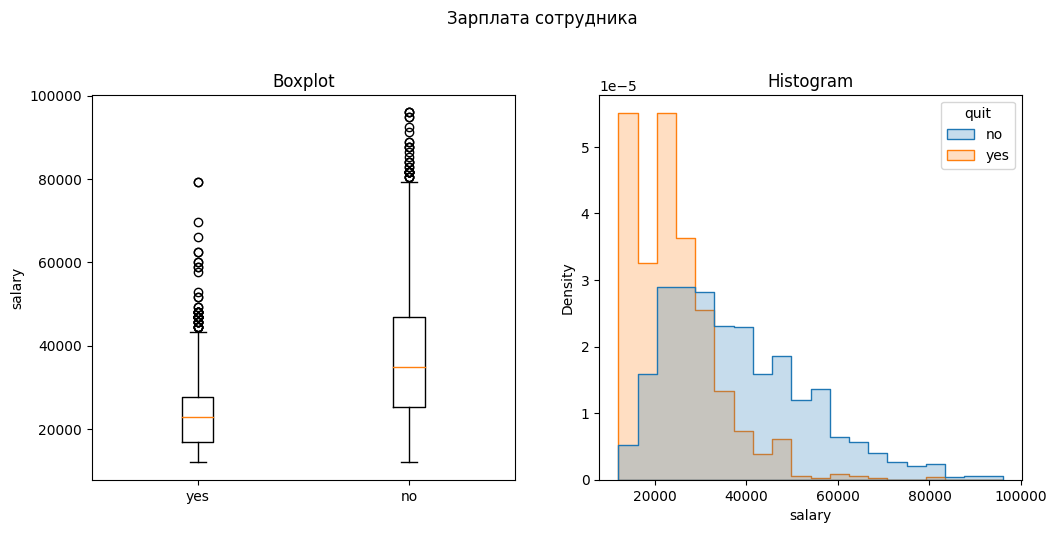

In [54]:
box_hist_plot_сompare_norm(train_quit_df, 'salary', 20, 'Зарплата сотрудника')

Теперь рассмотрим категориальные признаки:

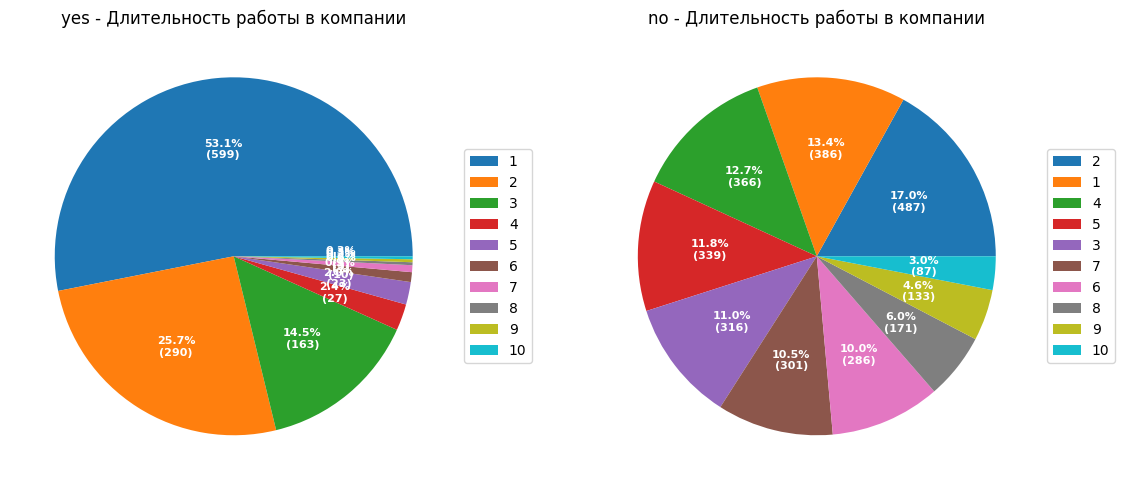

In [55]:
pie_chart_compare(train_quit_df, 'employment_years', 'Длительность работы в компании')

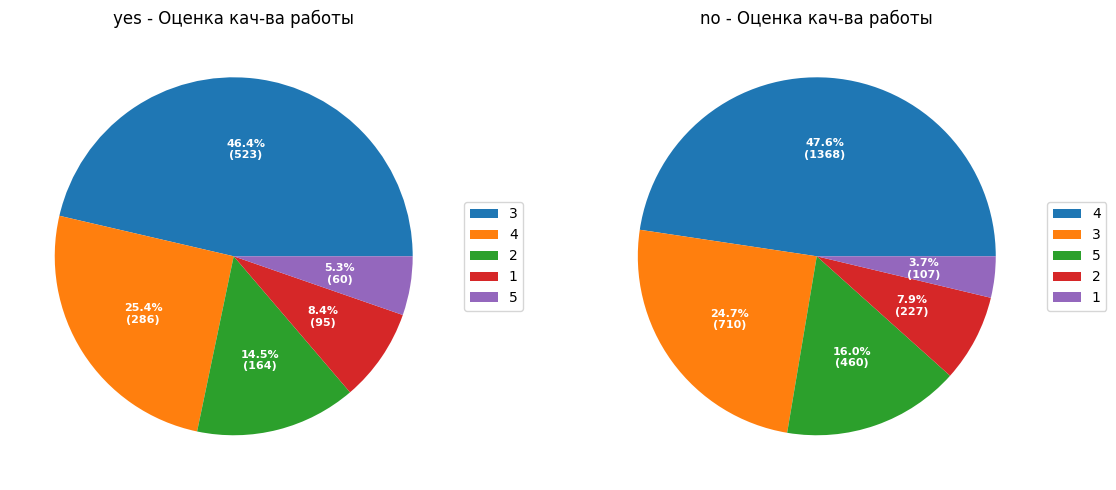

In [56]:
pie_chart_compare(train_quit_df, 'supervisor_evaluation', 'Оценка кач-ва работы')

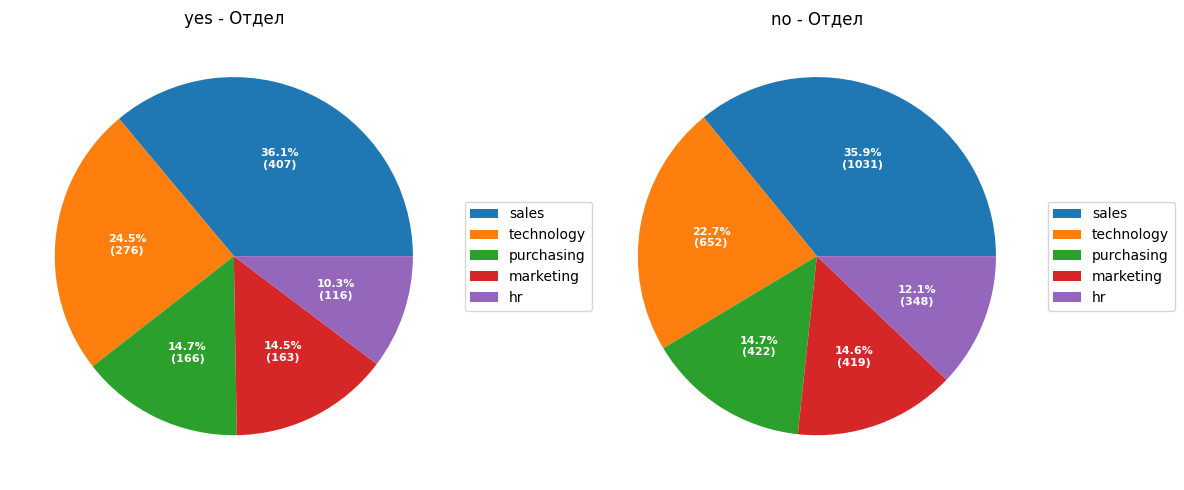

In [57]:
pie_chart_compare(train_quit_df, 'dept', 'Отдел')

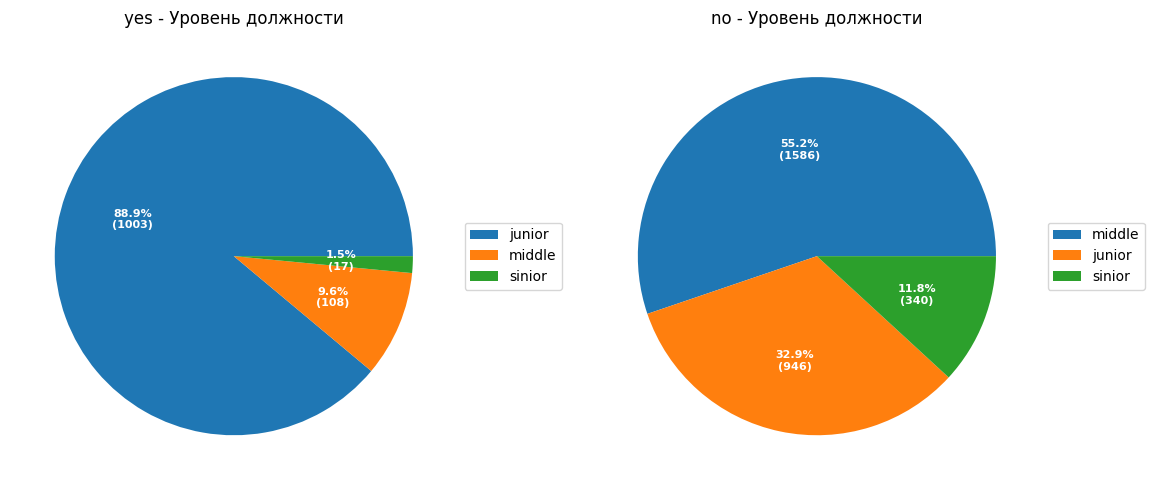

In [58]:
pie_chart_compare(train_quit_df, 'level', 'Уровень должности')

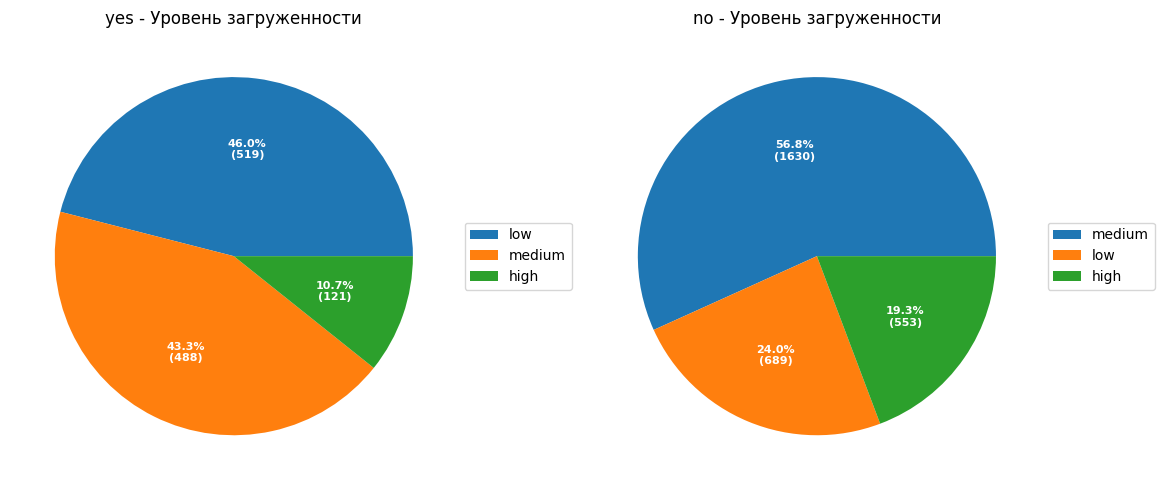

In [59]:
pie_chart_compare(train_quit_df, 'workload', 'Уровень загруженности')

**Вывод:** Из проведенного сравнительного анализа можно заключить, что "средний" уволившейся сотрудник:
* Проработал меньший срок в компании (1 год)
* Имеет уровень загруженности medium
* Является junior-ом
* Имеет меньшую зарплату (22 800)
* Работает в отделе "technology"
* Получил меньшую оценку кач-ва работы (3)

### Cравнение распределения признака `job_satisfaction_rate` для ушедших и оставшихся сотрудников

In [60]:
# Сравнение произведем по тестовым датасетам, предварительно объединив их
test_merged_df =  test_satisf_target_df.merge(test_quit_target_df, on='id')

,count,mean,std,min,25%,50%,75%,max
quit,,,,,,,,
no,1436.0,0.612040,0.199367,0.03,0.50,0.66,0.7600,1.00
yes,564.0,0.387713,0.185784,0.04,0.24,0.37,0.4925,0.97


Усы боксплота для категории 'yes': (-0.13875000000000004, 0.8712500000000001)
Усы боксплота для категории 'no': (0.10999999999999999, 1.15)


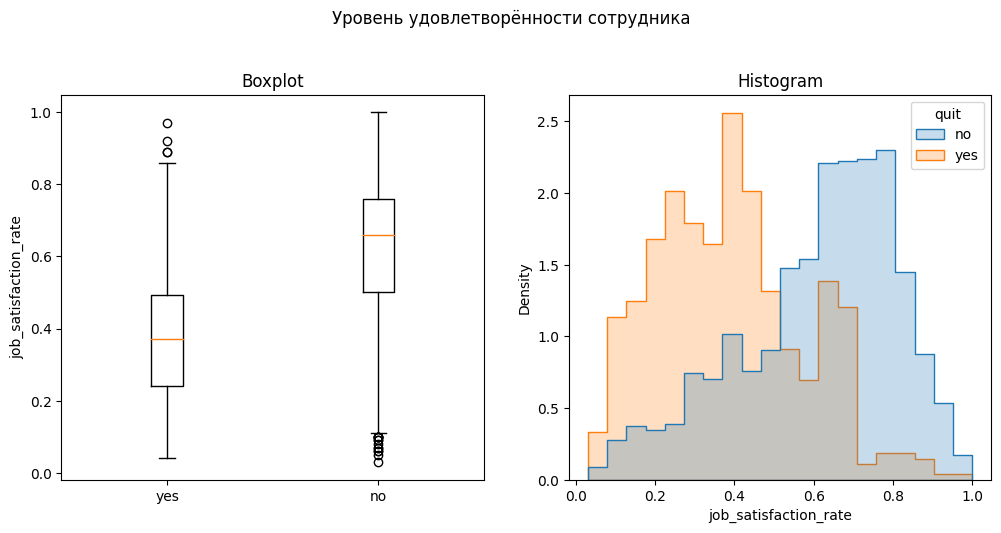

In [61]:
box_hist_plot_сompare_norm(test_merged_df, 'job_satisfaction_rate', 20, 'Уровень удовлетворённости сотрудника')

**Вывод:** Из графиков видно, что уровень удовлетворенности сотрудников (`job_satisfaction_rate`) выше у оставшихся сотрудников.

### Кореляционный анализ

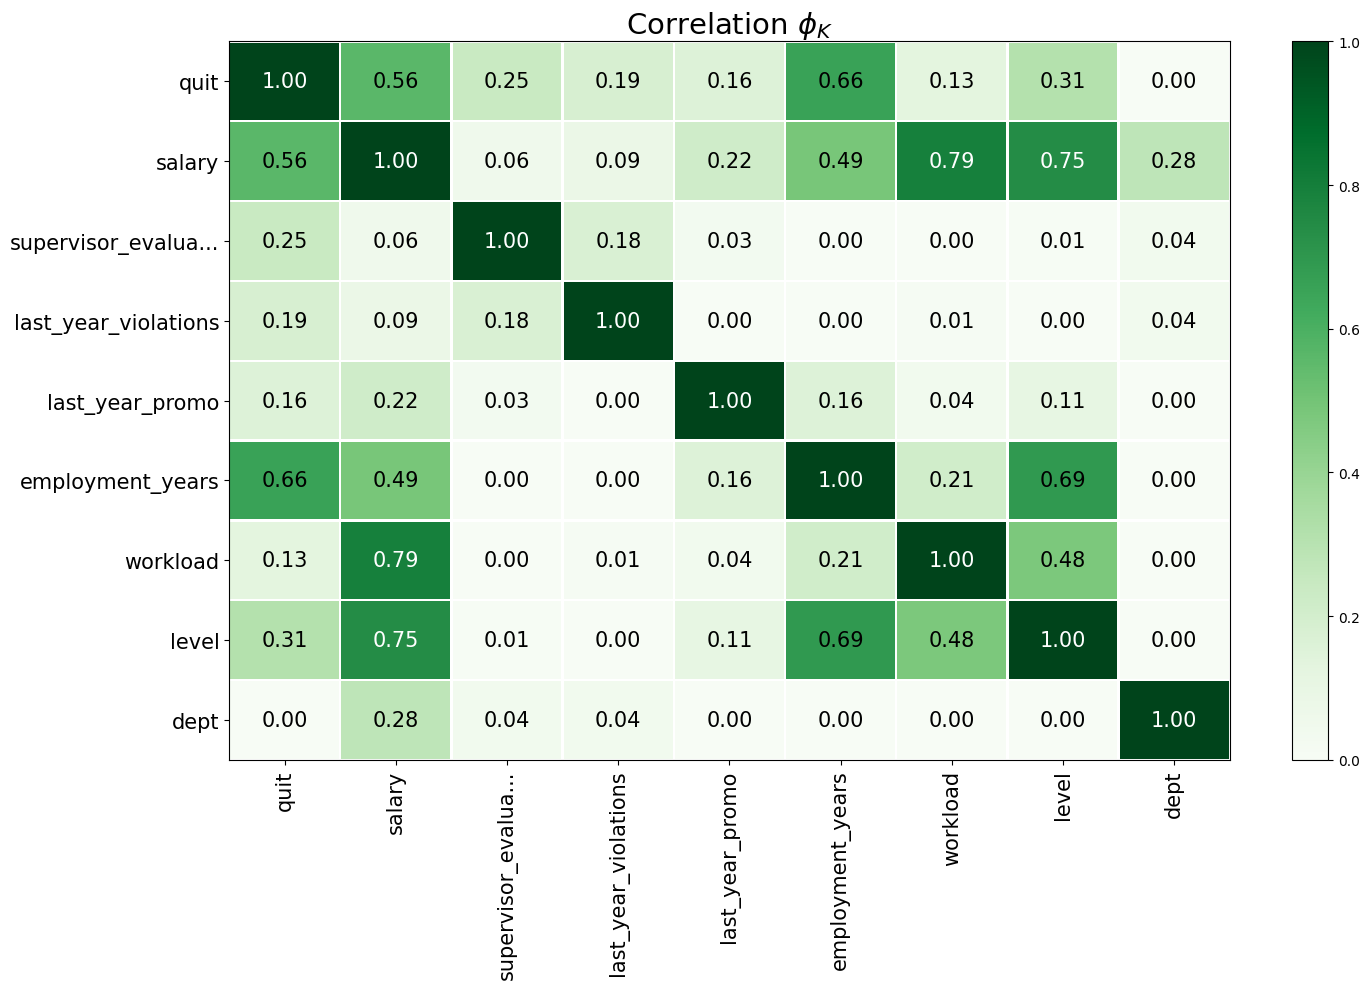

In [62]:
# Создадим список с названиями столбцов непрерывных признаков
interval_cols = ['salary']

phik_overview = phik_matrix(train_quit_df.drop('id', axis=1), interval_cols = interval_cols)

# Визуализация матрицы корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens', 
    title=r'Correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
)

С таргетом `quit` (увольнение сотрудника из компании) наиболее значительно коррелируют:
* `employment_years` - 0.66
* `salary` - 0.56
* `level` и `supervisor_evaluation` - 0.31 и 0,25

Все остальные признаки коррелируют незначительно - от 0,00 до 0,19.

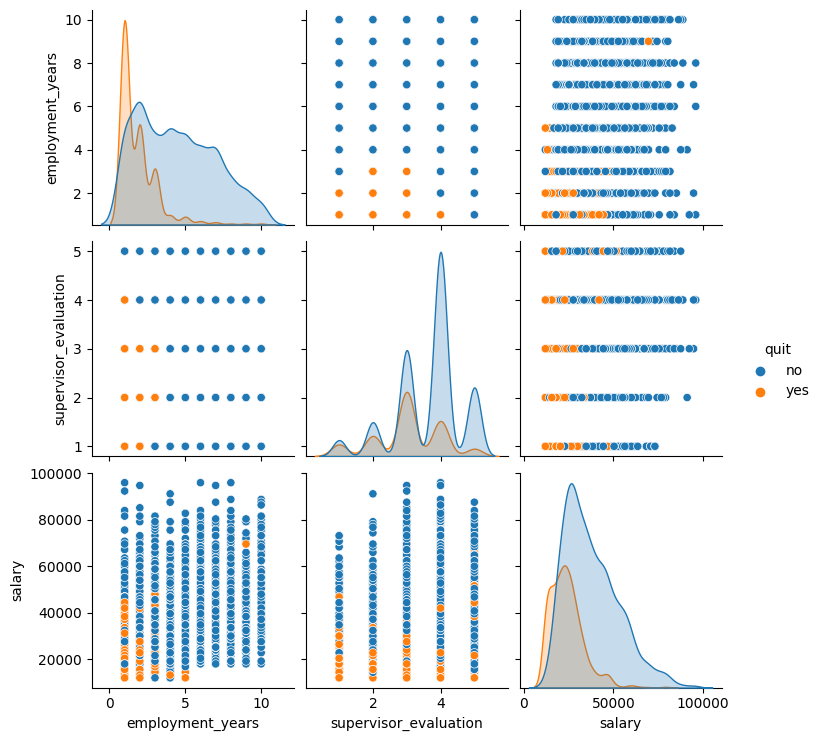

In [63]:
# Используем scatterplot matrix для анализа 
train_quit_df_scatter = train_quit_df[['employment_years', 'supervisor_evaluation', 'salary', 'quit']]
sns.pairplot(train_quit_df_scatter, hue='quit')

На полученной матрице рассеяния явно выраженной линейной связи между признаками не прослеживатся, при этом нет таких "облак" точек, которые можно было наблюдать для матрицы рассеяния количественного таргета (например, с признаком `salary`).

In [64]:
# Предварительно соединим таблицы тестовых датасетов (таргета и входных признаков)
test_quit_df_corr = test_satisf_features_df.merge(test_quit_target_df, on='id')

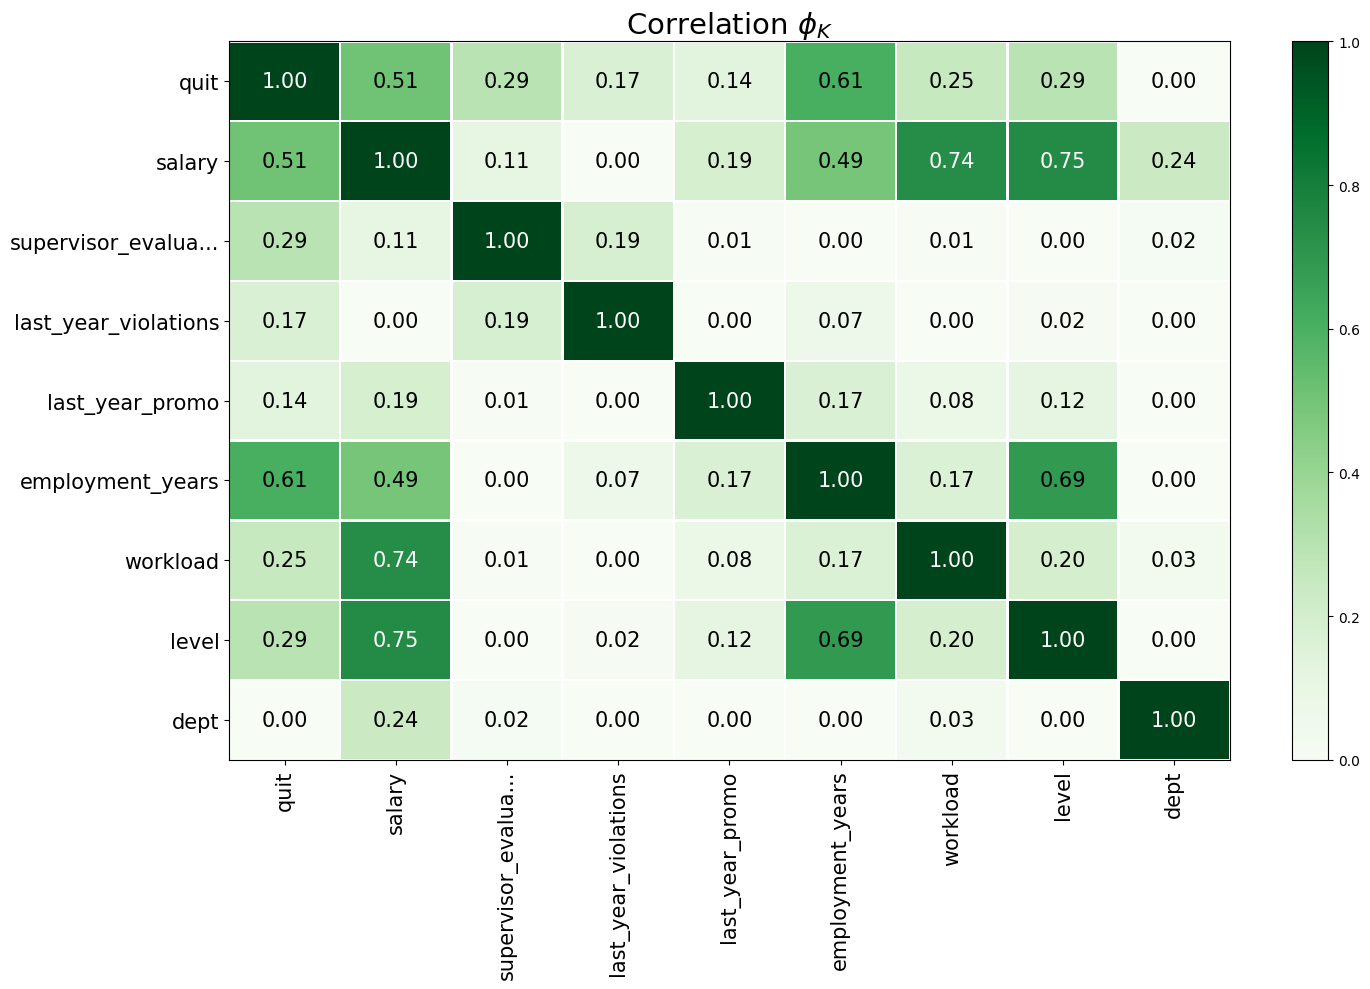

In [65]:
phik_overview = phik_matrix(test_quit_df_corr.drop('id', axis=1), interval_cols = interval_cols)

# Визуализация матрицы корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens', 
    title=r'Correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
)

Корреляция с таргетом входных признаков test-датасета аналогична train-датасету.

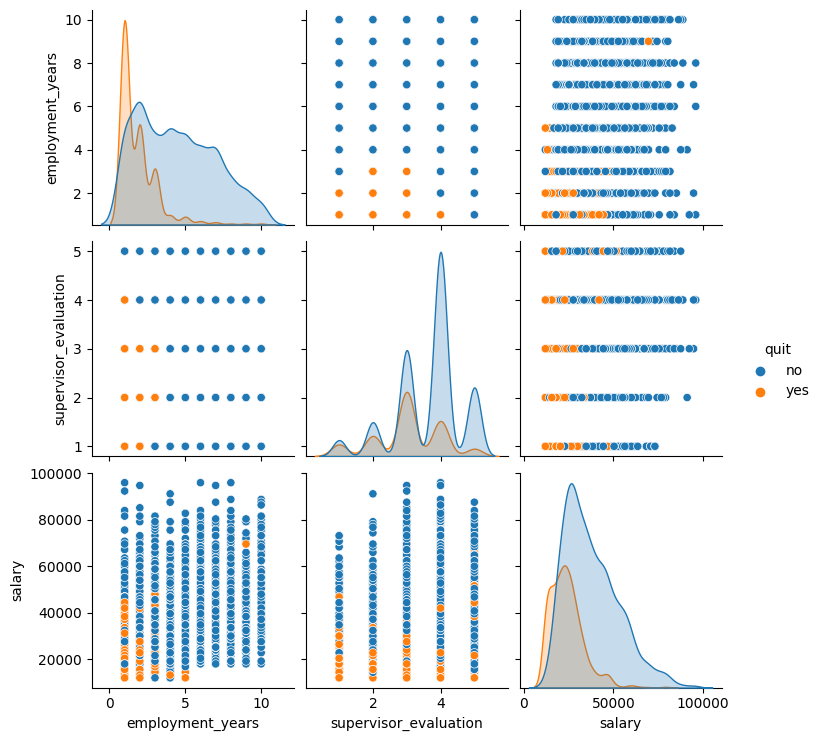

In [66]:
test_quit_df_scatter = train_quit_df[['employment_years', 'supervisor_evaluation', 'salary', 'quit']]
sns.pairplot(test_quit_df_scatter, hue='quit')

Взаимосвязи признаков test-датасета аналогичны train-датасету.

### Добавление нового входного признака

К тренировочной выборке `train_quit_df` добавим новый признак - `job_satisfaction_rate`, предсказанные лучшей моделью из 1 задачи:

In [67]:
y_train_pred = rs.predict(train_quit_df.drop(['id', 'quit'], axis=1))

In [68]:
train_quit_df['job_satisfaction_rate'] = y_train_pred
train_quit_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.657619
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.853529
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.364091
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


In [69]:
y_test_pred_quit = rs.predict(test_satisf_features_df.drop(['id'], axis=1))

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


In [70]:
test_satisf_features_df['job_satisfaction_rate'] = y_test_pred_quit
test_satisf_features_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.863333
1,686555,hr,junior,medium,1,no,no,4,30000,0.670417
2,467458,sales,middle,low,5,no,no,4,19200,0.654000
3,418655,sales,middle,low,6,no,no,4,19200,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,0.824643


## Пайплайн и обучение модели классификации

### Выборки датасета и пайплайн подготовки данных

In [71]:
# Сначала соберем тестовый датасет 
test_quit_df = test_satisf_features_df.merge(test_quit_target_df, on='id')

In [72]:
# Определим тестовую выборку и таргет
X_test_2 = test_quit_df.drop(['id', 'quit'], axis=1)
y_test_2 = test_quit_df['quit']

Определим тренировочную выборку для предсказания `quit`:

In [73]:
# Удалим id и произведем проверку на дубликаты
X_train_2_init = train_quit_df.drop(['id'], axis=1)
X_train_2_init.duplicated().sum()

1413

Было найдено 1413 строк-дубликатов после удаления признака `id`. Удалим их:

In [74]:
X_train_2_init = X_train_2_init.drop_duplicates()
X_train_2_init.shape

(2587, 10)

Явные дубликаты после удаления `id` были успешно удалены.

In [75]:
X_train_2 = X_train_2_init.drop(['quit'], axis=1)
y_train_2 = X_train_2_init['quit']

In [76]:
# Колонки которые нужно закодировать те же самые, добавим новый признак в num_columns
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

# Кодирование целевого признака
label_encoder = LabelEncoder()
y_train_2 = label_encoder.fit_transform(y_train_2)
y_test_2 = label_encoder.transform(y_test_2)

In [77]:
# Посмотрим как закодировался таргет
label_encoder.inverse_transform([0, 1])

array(['no', 'yes'], dtype=object)

In [78]:
# Определим пайплайн предобработки данных для 2 модели
ohe_pipe_2 = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False) # Работает только с sklearn от 1.0.0 и выше
        )
    ]
)

ord_pipe_2 = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')

        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['sinior', 'middle', 'junior'],
                    ['high', 'medium', 'low']   
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor_2 = ColumnTransformer(
    [
        ('ohe', ohe_pipe_2, ohe_columns),
        ('ord', ord_pipe_2, ord_columns),
        ('num', StandardScaler(), num_columns)       
    ], 
    remainder='passthrough'
)

Исследуем 3 модели (*LogisticRegression*, *KNeighborsClassifier*, *DecisionTreeClassifier*) с несколькими гиперпараметрами для каждой. В кач-ве метрики используется *ROC-AUC* (или площадь под roc-кривой), которая позволяет оценивать модель при различных порогах классификации и подходит для бинарной классификации с несбалансированным таргетом.

In [79]:
# Определим итоговый пайплайн
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [80]:
# Определим словарь гиперпараметров (с вариацией масштабирования и моделей)
param_grid = [
    # LogisticRegression
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), RobustScaler(), MinMaxScaler()]
    },
    # KNeighborsClassifier
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,10),
        'preprocessor__num': [StandardScaler(), RobustScaler(), MinMaxScaler()]
    },
    # DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(5,10),
        'models__max_features': range(5,10),
        'models__min_samples_split': range(5, 12),
        'preprocessor__num': [StandardScaler(), RobustScaler(), MinMaxScaler()]
    },
]

# Для подбора гиперпараметров используем случайный поиск
gs = GridSearchCV(
    pipe_final_2,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

gs.fit(X_train_2, y_train_2)

print('Лучшая модель и её параметры:\n\n', gs.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', gs.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


**Вывод:** Лучшей моделью оказалась модель Дерева решений (*DecisionTreeClassifier*) с *max_depth* = 6, *max_features* = 9, *min_samples_split* = 10 и методом масштабирования *StandardScaler*. Метрика для лучшей модели составила 90.5%.

Протестируем модель на тестовых данных:

In [81]:
probs_one_y_test_2 = gs.predict_proba(X_test_2)[:, 1]
print(f'Значение метрики ROC-AUC на тестовой выборке: {roc_auc_score(y_test_2, probs_one_y_test_2)}') 

Значение метрики ROC-AUC на тестовой выборке: 0.9180267043995338


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


Значение метрики ROC-AUC на тестовой выборке составило 92% - удовлетворительный результат.

Чтобы лучше понять работу модели проведем анализ важности признаков.

In [82]:
# Подготовим датасет перед анализом
X_train_df_init = gs.best_estimator_['preprocessor'].fit_transform(X_train_2)
X_train_df = pd.DataFrame(X_train_df_init, columns = gs.best_estimator_['preprocessor'].get_feature_names_out())

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [83]:
# Формируем таблицу важности признаков и сортируем её
feature_importances = pd.DataFrame(
    {
        'Feature': X_train_df.columns,
        'Importance': gs.best_estimator_['models'].feature_importances_
    }).sort_values('Importance', ascending=False)

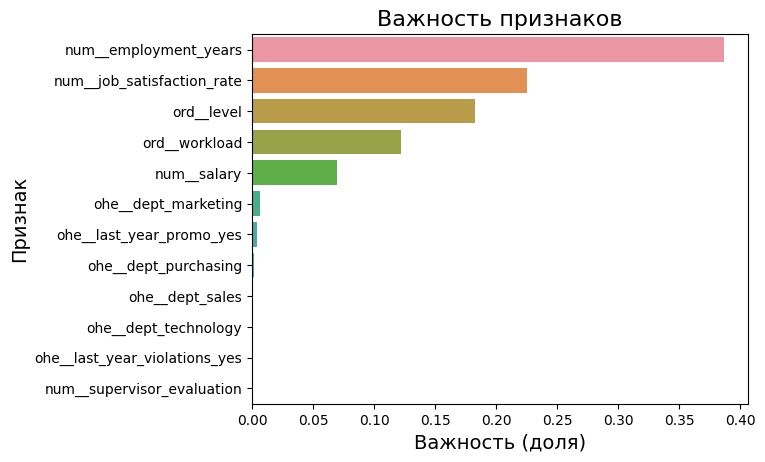

In [84]:
# Опредилим таблицу
df_impr = feature_importances.sort_values(by='Importance', ascending=False)

# Построим столбчатый график для наглядности
ax = sns.barplot(data=feature_importances, x="Importance", y="Feature")

ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность (доля)', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)

plt.show()

Из столбчатой диаграммы важности признаков видно, что наиболее значимыми признаками оказались (в порядке убывания):
* `employment_years` (длительность работы в компании (в годах))
* `job_satisfaction_rate` (уровень удовлетворённости сотрудника работой в компании)
* `level` (уровень занимаемой должности)
* `workload` (Уровень загруженности)
* `salary` (ежемесячная зарплата сотрудника)

## Вывод 

HR-аналитики компании "Работа с заботой" предоставляют бизнесу услуги по оптимизации управления персоналом: с целью избежать финансовых потерь и оттока сотрудников. Компанией были предоставлены данные с характеристиками сотрудников (отдел, в котором работает сотрудник; уровень занимаемой должности; уровень загруженности сотрудника; длительность работы в компании (в годах); повышение за последний год; нарушение сотрудником трудового договора за последний год; оценка качества работы сотрудника, которую дал руководитель; ежемесячная зарплата сотрудника; уровень удовлетворённости сотрудника работой в компании) на основе которых было необходимо разработать 2 модели: 1-ая модель для предсказания уровня удовлетвореннности работой сотрудника; 2-ая модель для предсказания увольнения/ухода сотрудника из компании. 

Предварительно была произведна предобработка данных - дубликатов выявлено не было, при этом были найдено малое число пропусков.

Для поиска наилучших моделей предсказания уровня удовлетворённости и ухода сотрудника были использованы пайплайны - путем перебора методов масштабирования и моделей с использованием автоматизированного поиска лучших параметров (RandomizedSearchCV и GridSearchCV) были определены наилучшие модели - *DecisionTreeRegressor* со значением *max_depth* = 13 и *max_features* = 10 и *DecisionTreeClassifier* со значением *max_depth* = 6, *max_features* = 9 и *min_samples_split* = 10. 

По результатам исследовательского анализа данных и результатов модели выяснилось, что сильнее всего на (не)уход сотрудника влияют:
* длительность работы в компании (в годах) - более "старые" сотрудники уходят реже; 
* уровень удовлетворённости сотрудника работой в компании - сотрудники с высоким уровнем удовлетворенности уходят реже;
* уровень занимаемой должности - сотрудники с высоким уровнем должности уходят реже;
* уровень загруженности - сотрудники с высокой нагрузкой уходят реже; 
* ежемесячная зарплата сотрудника - сотрудники с высокой оплатой труда уходят реже;

Исходя из полученных результатов можно предложить для бизнеса следующее:
* Мотивация новых сотрудников к долгосрочному сотрудничеству - это поощрения за определенный проработанный период (например, год), причем чем выше срок - тем серьезнее поощрение. 

* Предоставление возможностей для карьерного роста и увеличение профессиональных компетенций внутри компании - сюда можно включить предоставление программы обучения, возможности наставничества и четкие пути карьерного роста, чтобы мотивировать сотрудников оставаться в организации.

* Адекватное распределение и делегирование задач для сотрудников: таким образом, чтобы каждый сотрудник получал соответствующий своему профессиональному уровню таск, на который он мог бы эффективно потратить свое рабочее время. Также возможно привлечение сотрудника к решению дополнительных задач, если у последнего появляется такая возможность.

* Отслеживание конкурентноспособности компании в плане зарплат на рынке - поддержание конкуретноспособного уровня оплаты труда, бонусные программы, основанные на результатах работы, участие в прибыли компании и т.д. 

* Признание результатов работы сотрудника и грамотно выстроенная обратная связь - введение прозрачного для всех сотрудников процесса оценки эффективности последних и поощрение наиболее отличившихся. Вместе с этим необходимо проведение опросов для оценки уровня удовлетворенности сотрудников, открытые каналы обратной связи для решения возникающих проблем.

* При этом также необходимо повышение уровня менеджеров, которые бы смогли грамотно управлять приведенными выше процессами и положительно повлиять на удовлетворенность и вовлеченность сотрудников.